In [46]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
import textstat
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [9]:
#Einlesen der Trainingsdaten Nummer 1
dataset = panda.read_csv("training3.csv", sep=";")
dataset

,tweet,classification
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0
3,@dushanwegner Amis hätten alles und jeden gewä...,0
4,@spdde kein verläßlicher Verhandlungspartner. ...,1
...,...,...
5004,Gegens. Zul. zu Patenamt &amp; gegenseitige An...,0
5005,"@GlasenappHenrik Zu Merkel fällt mir nur ein, ...",1
5006,@KokoLores20 @krippmarie Ein richtiges Zeichen...,1
5007,"@Hartes_Geld ,Honecker‘Merkel macht uns zur ,D...",1


In [10]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

                                               tweet  classification  \
0  @corinnamilborn Liebe Corinna, wir würden dich...               0   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...               0   
2  @ahrens_theo fröhlicher gruß aus der schönsten...               0   
3  @dushanwegner Amis hätten alles und jeden gewä...               0   
4  @spdde kein verläßlicher Verhandlungspartner. ...               1   

   text length  
0          109  
1          142  
2           69  
3          140  
4          136  


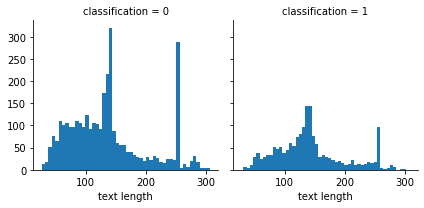

In [12]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='classification')
graph.map(plt.hist, 'text length', bins=50)

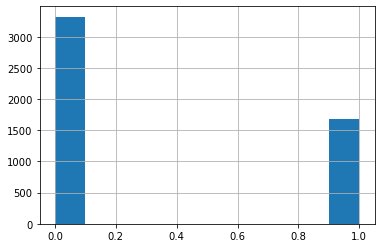

In [14]:
dataset['classification'].hist()

In [15]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [16]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("german")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset[["tweet","processed_tweets"]].head(10))

                                               tweet  \
0  @corinnamilborn Liebe Corinna, wir würden dich...   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...   
2  @ahrens_theo fröhlicher gruß aus der schönsten...   
3  @dushanwegner Amis hätten alles und jeden gewä...   
4  @spdde kein verläßlicher Verhandlungspartner. ...   
5  @Dirki_M Ja, aber wo widersprechen die Zahlen ...   
6  @milenahanm 33 bis 45 habe ich noch gar nicht ...   
7  @jayxderxmensch @jayxthexhuman Wieso? Was find...   
8  @tagesschau Euere AfD Hetze wirkt. Da könnt ih...   
9  Deutsche Medien, Halbwahrheiten und einseitige...   

                                    processed_tweets  
0  lieb corinna w rden gern moderatorin f r gewin...  
1  ja recht tweet missverst ndlich bverfg sachlei...  
2           fr hlicher gru sch nsten stadt welt theo  
3  ami h tten gew hlt hillari wollten fortsetzung...  
4  verl licher verhandlungspartn nachkarteln sond...  
5  ja widersprechen zahlen denen verlinkten artik... 

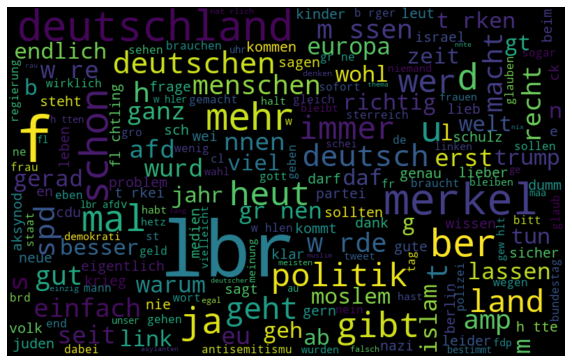

In [17]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

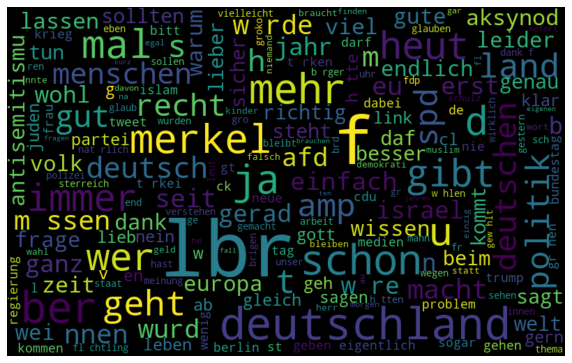

In [19]:
# visualizing which of the word is most commonly used for OTHER
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['classification'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

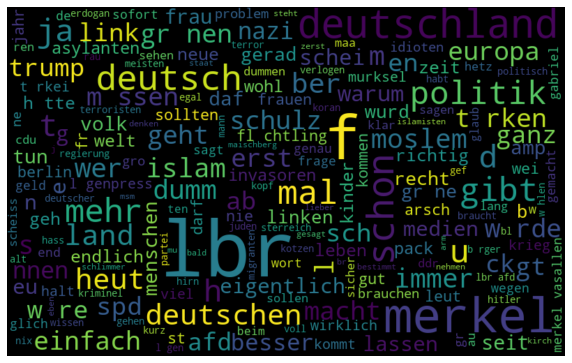

In [20]:
# visualizing which of the word is most commonly used for OFFENSE
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['classification'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
##Feature Engineering

#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<5009x2107 sparse matrix of type '<class 'numpy.float64'>'
	with 34488 stored elements in Compressed Sparse Row format>

In [65]:
## Running various model USING TFIDF without additional features

# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['classification'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       667
           1       0.72      0.30      0.42       335

    accuracy                           0.73      1002
   macro avg       0.72      0.62      0.62      1002
weighted avg       0.72      0.73      0.69      1002

Logistic Regression, Accuracy Score: 0.7265469061876247


In [66]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       667
           1       0.72      0.42      0.53       335

    accuracy                           0.75      1002
   macro avg       0.74      0.67      0.68      1002
weighted avg       0.75      0.75      0.73      1002

Random Forest, Accuracy Score: 0.7514970059880239


In [67]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.77      0.41      0.53       667
           1       0.39      0.76      0.52       335

    accuracy                           0.53      1002
   macro avg       0.58      0.58      0.53      1002
weighted avg       0.64      0.53      0.53      1002

Naive Bayes, Accuracy Score: 0.5259481037924152


In [27]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       667
           1       0.66      0.50      0.57       335

    accuracy                           0.75      1002
   macro avg       0.72      0.69      0.69      1002
weighted avg       0.74      0.75      0.74      1002

SVM, Accuracy Score: 0.7455089820359282


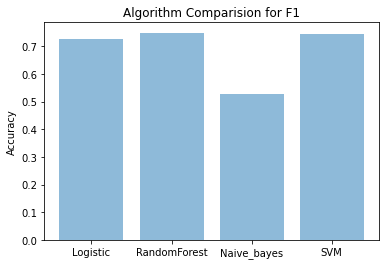

In [28]:

objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

In [29]:
##Sentiment Analysis, using polarity scores as features

sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.0,1.000,0.0000,0.0,1.0,0.0
1,0.178,0.0,0.822,-0.5994,0.0,1.0,0.0
2,0.000,0.0,1.000,0.0000,0.0,1.0,0.0
3,0.000,0.0,1.000,0.0000,0.0,1.0,0.0
4,0.218,0.0,0.782,-0.5994,0.0,1.0,1.0
...,...,...,...,...,...,...,...
5004,0.000,0.0,1.000,0.0000,0.0,0.0,3.0
5005,0.000,0.0,1.000,0.0000,0.0,1.0,0.0
5006,0.000,0.0,1.000,0.0000,0.0,2.0,0.0
5007,0.119,0.0,0.881,-0.5994,0.0,1.0,0.0


In [30]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(5009, 2114)

In [31]:
# Running the model Using TFIDF with some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression,Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       667
           1       0.74      0.33      0.46       335

    accuracy                           0.74      1002
   macro avg       0.74      0.64      0.64      1002
weighted avg       0.74      0.74      0.70      1002

Logistic Regression,Accuracy Score: 0.7375249500998003


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       667
           1       0.69      0.37      0.48       335

    accuracy                           0.73      1002
   macro avg       0.72      0.64      0.65      1002
weighted avg       0.73      0.73      0.71      1002

Random Forest, Accuracy Score: 0.7345309381237525


In [34]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.78      0.48      0.59       667
           1       0.41      0.73      0.52       335

    accuracy                           0.56      1002
   macro avg       0.59      0.60      0.56      1002
weighted avg       0.65      0.56      0.57      1002

Naive Bayes, Accuracy Score: 0.5588822355289421


In [35]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       667
           1       0.66      0.50      0.57       335

    accuracy                           0.75      1002
   macro avg       0.72      0.68      0.69      1002
weighted avg       0.74      0.75      0.74      1002

SVM, Accuracy Score: 0.7455089820359282


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


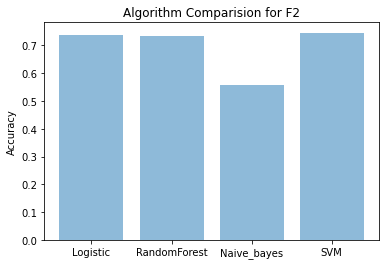

In [36]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

In [37]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,0.032205,0.049631,-0.011359,0.009783,0.068732
1,0.020851,-0.054595,0.018695,-0.014039,0.013011
2,-0.064685,-0.032972,-0.058844,0.087778,-0.007100
3,-0.060448,-0.107578,-0.058057,-0.057463,0.032162
4,-0.029599,0.014106,-0.121555,0.099206,0.076347
...,...,...,...,...,...
5004,-0.065723,0.000352,-0.080116,0.188295,0.000326
5005,0.052463,-0.067984,0.001628,0.104841,0.022102
5006,0.008460,0.000135,-0.085592,0.003292,-0.000783
5007,-0.061452,0.014383,-0.030151,-0.013043,0.017069


In [38]:

# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(5009, 2119)

In [39]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       667
           1       0.73      0.32      0.44       335

    accuracy                           0.73      1002
   macro avg       0.73      0.63      0.63      1002
weighted avg       0.73      0.73      0.70      1002

Logistic Regression, Accuracy Score: 0.7315369261477046


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       667
           1       0.75      0.26      0.39       335

    accuracy                           0.72      1002
   macro avg       0.73      0.61      0.60      1002
weighted avg       0.73      0.72      0.68      1002

Random Forest, Accuracy Score: 0.7235528942115769


In [41]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.78      0.48      0.59       667
           1       0.41      0.73      0.52       335

    accuracy                           0.56      1002
   macro avg       0.59      0.60      0.56      1002
weighted avg       0.65      0.56      0.57      1002

Naive Bayes, Accuracy Score: 0.5588822355289421


In [42]:
X = panda.DataFrame(modelling_features)
y = dataset['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       667
           1       0.64      0.49      0.56       335

    accuracy                           0.74      1002
   macro avg       0.71      0.68      0.69      1002
weighted avg       0.73      0.74      0.73      1002

SVM, Accuracy Score: 0.7385229540918163


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


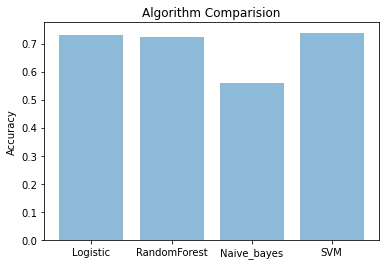

In [43]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [47]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    
    #  Flesch–Kincaid readability tests are readability tests 
    #  designed to indicate how difficult a passage in English is to understand. 
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade 
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    
    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)

In [48]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(5009, 2127)

In [50]:
# Running the model Using TFIDF with enhanced features

X = panda.DataFrame(modelling_features_enhanced)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       657
           1       0.64      0.18      0.28       345

    accuracy                           0.68      1002
   macro avg       0.66      0.56      0.54      1002
weighted avg       0.67      0.68      0.62      1002

Logistic Regression, Accuracy Score: 0.6816367265469062


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_features,y_train)
y_preds = rf.predict(X_test_features)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.71      0.96      0.82       657
           1       0.78      0.24      0.37       345

    accuracy                           0.72      1002
   macro avg       0.74      0.60      0.59      1002
weighted avg       0.73      0.72      0.66      1002

Random Forest, Accuracy Score: 0.7155688622754491


In [53]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_features,y_train)
y_preds = nb.predict(X_test_features)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.76      0.53      0.63       657
           1       0.43      0.68      0.53       345

    accuracy                           0.58      1002
   macro avg       0.60      0.61      0.58      1002
weighted avg       0.65      0.58      0.59      1002

Naive Bayes, Accuracy Score: 0.5828343313373253


In [54]:
X = panda.DataFrame(modelling_features_enhanced)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test_helo,y_preds)
report = classification_report( y_test_helo, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       657
           1       0.81      0.04      0.07       345

    accuracy                           0.67      1002
   macro avg       0.74      0.52      0.43      1002
weighted avg       0.71      0.67      0.55      1002

SVM, Accuracy Score: 0.6656686626746507


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


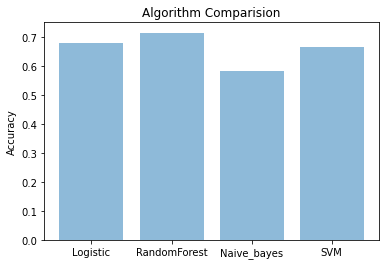

In [55]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [56]:
#f1,f3 and f4 combined

tfidf_a = tfidf.toarray()
modelling_features_one = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_one.shape

(5009, 2120)

In [57]:
X = panda.DataFrame(modelling_features_one)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.90      0.01      0.03       657
           1       0.35      1.00      0.51       345

    accuracy                           0.35      1002
   macro avg       0.62      0.51      0.27      1002
weighted avg       0.71      0.35      0.19      1002

SVM, Accuracy Score: 0.3522954091816367


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [58]:
#f1,f2 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_two = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_two.shape

(5009, 2122)

In [59]:
X = panda.DataFrame(modelling_features_two)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       657
           1       0.82      0.04      0.08       345

    accuracy                           0.67      1002
   macro avg       0.74      0.52      0.44      1002
weighted avg       0.72      0.67      0.55      1002

SVM, Accuracy Score: 0.6666666666666666


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [60]:
#f2,f3 and f4 combined
modelling_features_three = np.concatenate([final_features,fFeatures],axis=1)
modelling_features_three.shape

(5009, 15)

In [61]:
X = panda.DataFrame(modelling_features_three)
y = dataset['classification'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )


              precision    recall  f1-score   support

           0       0.66      1.00      0.79       657
           1       0.00      0.00      0.00       345

    accuracy                           0.66      1002
   macro avg       0.33      0.50      0.40      1002
weighted avg       0.43      0.66      0.52      1002

SVM, Accuracy Score: 0.655688622754491


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
# the most important feature we found to be was the tf-idf scores which helps in better classification of hate speech.
# Doc2vec columns are not found to be very significant in classification purpose as it makes very less difference when 
#its removed form the feature set. SVM's and RF's performance is hugely impacted when tf-idf scores are not included in the feature set.

In [63]:
X = panda.DataFrame(modelling_features_two)
y = dataset['classification'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.67      0.95      0.79       657
           1       0.56      0.13      0.21       345

    accuracy                           0.67      1002
   macro avg       0.62      0.54      0.50      1002
weighted avg       0.64      0.67      0.59      1002

Logistic Regression, Accuracy Score: 0.6656686626746507


G:\Program Files (x86)\Neuer Ordner\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
X = panda.DataFrame(modelling_features_three)
y = dataset['classification'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.68      0.83      0.74       657
           1       0.43      0.25      0.32       345

    accuracy                           0.63      1002
   macro avg       0.55      0.54      0.53      1002
weighted avg       0.59      0.63      0.60      1002

Random Forest, Accuracy Score: 0.627744510978044
